<a href="https://colab.research.google.com/github/Supakrit65/credit-card-fraud-analysis-modeling/blob/main/model_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detecion

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from category_encoders import WOEEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive (for Google Colab)
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
os.chdir('drive/My Drive/ML/Projects/credit_card_fraud')
os.listdir()

Mounted at /content/drive


['creditcard.csv',
 'card_transdata.csv',
 'shallow_nn',
 'shallow_nn_b',
 'detect credit card fraud.ipynb',
 'dataset',
 'main.ipynb',
 'eda.ipynb',
 'debug.ipynb',
 'model_prediction.ipynb']

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Validation Set Evaluation
Precision: 0.7335
Recall: 0.8581
F1 Score: 0.7909
ROC AUC: 0.9281


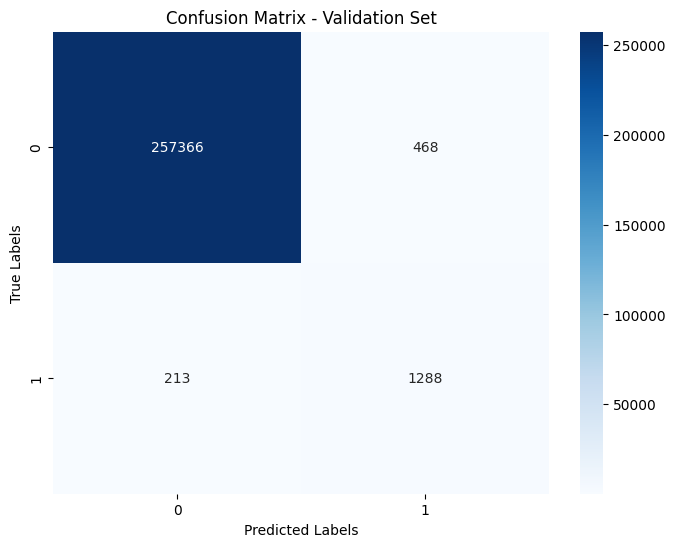


Test Set Evaluation
Precision: 0.3222
Recall: 0.1445
F1 Score: 0.1995
ROC AUC: 0.5717


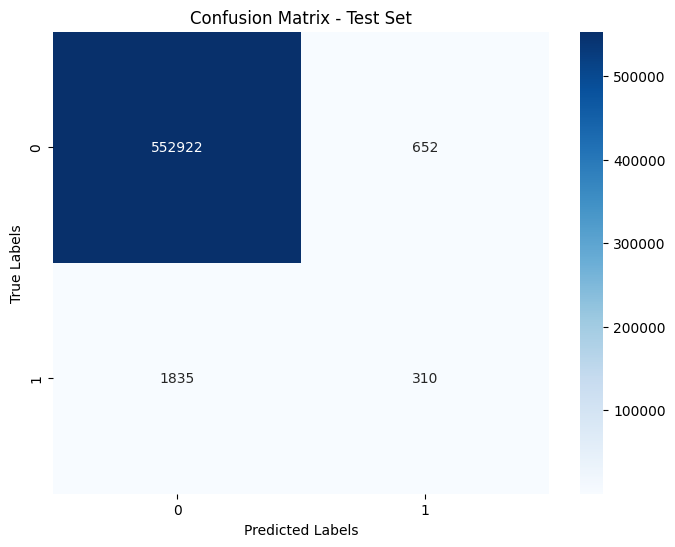

In [ ]:
train_df = pd.read_csv('dataset/fraudTrain.csv')
test_df = pd.read_csv('dataset/fraudTest.csv')

# Separate features and target
X = train_df.drop(columns=['is_fraud'])
y = train_df['is_fraud']
X_test = test_df.drop(columns=['is_fraud'])
y_test = test_df['is_fraud']

label_encoder = LabelEncoder()
X['gender'] = label_encoder.fit_transform(X['gender'])
X_test['gender'] = label_encoder.transform(X_test['gender'])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply WOEEncoder for categorical variables and scale features
woe_encoder = WOEEncoder()
scaler = RobustScaler()

X_train_encoded = woe_encoder.fit_transform(X_train, y_train)
X_val_encoded = woe_encoder.transform(X_val)
X_test_encoded = woe_encoder.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Address class imbalance with SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smotetomek.fit_resample(X_train_scaled, y_train)

# Initialize XGBoost Classifier and StratifiedKFold for cross-validation
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameters for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_classifier, param_grid=param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Best model evaluation on validation set
y_pred_val = grid_search.predict(X_val_scaled)
print("Validation Set Evaluation")
print(f"Precision: {precision_score(y_val, y_pred_val):.4f}")
print(f"Recall: {recall_score(y_val, y_pred_val):.4f}")
print(f"F1 Score: {f1_score(y_val, y_pred_val):.4f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_pred_val):.4f}")

# Confusion Matrix Visualization for Validation Set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

y_pred_test = grid_search.predict(X_test_scaled)
print("\nTest Set Evaluation")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_test):.4f}")

# Confusion Matrix Visualization for Test Set
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()